In [1]:
import safe as sf
import datamol as dm

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


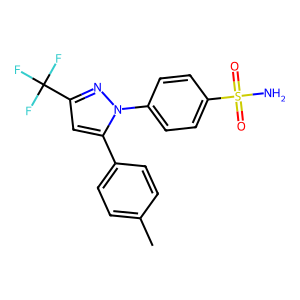

In [2]:
celecoxib = "Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)cc1"
celecoxib_mol = dm.to_mol(celecoxib)

display(dm.to_image(celecoxib_mol))

### Encoding

Here we encode the SMILES string representation for celecoxib (an NSAID) into a SAFE string

In [3]:
safe_str = sf.encode(celecoxib_mol)

print(safe_str)

print(f"Representation using {len(safe_str.split('.'))} fragments")

c14ccc(S(N)(=O)=O)cc1.Cc1ccc5cc1.c15cc3nn14.C3(F)(F)F
Representation using 4 fragments


Any SAFE string is also a valid SMILES string and can be read directly by RDKit

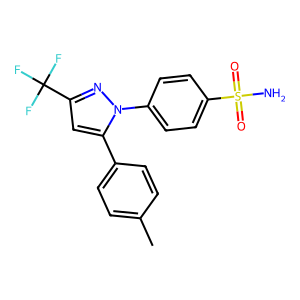

In [4]:
reconstructed = dm.to_mol(safe_str)

display(dm.to_image(reconstructed))

assert dm.same_mol(celecoxib_mol, reconstructed)

### Decoding

Each SAFE fragment is a valid molecule (i.e., a fragment); however, we need to use the decoder to recover molecules from the fragment in which not all attachment points are fulfilled

In [5]:
safe_fragment = safe_str.split(".")
safe_fragment

['c14ccc(S(N)(=O)=O)cc1', 'Cc1ccc5cc1', 'c15cc3nn14', 'C3(F)(F)F']

In [6]:
# The following will fail because the attachmment points are not fulfilled
dm.to_mol(safe_fragment[0])

[14:45:54] SMILES Parse Error: unclosed ring for input: 'c14ccc(S(N)(=O)=O)cc1'


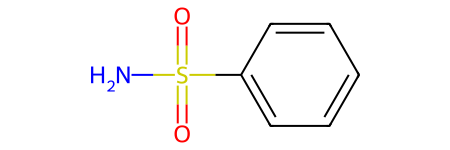

In [7]:
sf.decode(safe_fragment[0], as_mol=True)

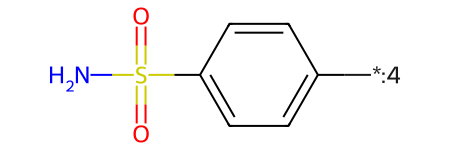

In [8]:
# To keep the attachment points, we can set remove_dummies=False
sf.decode(safe_fragment[0], as_mol=True, remove_dummies=False)

### Displaying a SAFE encoding

We can visualize a SAFE string, highlighting each of the fragments which compose it

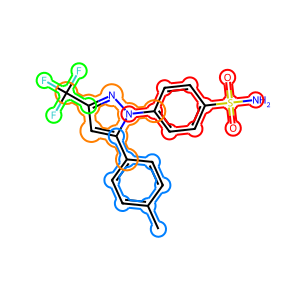

In [9]:
sf.to_image(safe_str)

## Molecular Design (what we care about)

In [10]:
import os

os.environ['TOKENIZERS_PARALLELISM'] = "false"

We can load the pretrained SAFE model, SAFE-GPT, which we will use for molecular design

In [11]:
designer = sf.SAFEDesign.load_default(verbose=True)

designer.model

/home/fts_g_ucla_edu/.conda/envs/reinvent/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


SAFEDoubleHeadsModel(
  (transformer): GPT2Model(
    (wte): Embedding(1880, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=1880, bias=False)
  (multiple_choice_head): PropertyHead(
    (summary): Linear(in_features=768, out_features=64, bias=True)
    

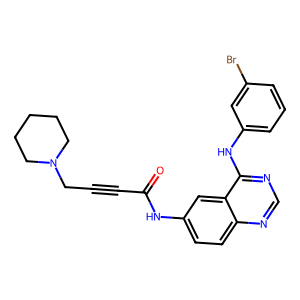

In [12]:
candidate_smiles = "O=C(C#CCN1CCCCC1)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1"
candidate_mol = dm.to_mol(candidate_smiles)

dm.to_image(candidate_mol)

In [13]:
generated_smiles = designer.de_novo_generation(sanitize=True, n_samples_per_trial=12)

generated_smiles[:5]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/fts_g_ucla_edu/.conda/envs/reinvent/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:535: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
2024-07-30 14:45:57.099 | INFO     | safe.sample:de_novo_generation:577 - After sanitization, 12 / 12 (100.00 %) generated molecules are valid !


['CNC(=O)CCCC(=O)N1CCC[C@H]2[C@H]1CCN2c1cncc(C#N)n1',
 'O=c1ccc(-c2cccc(CCO)c2)nn1-c1cccc(Br)c1',
 'CC[C@@H](NC(=O)[C@@H]1CCCC[C@H]1C(=O)N1CC[C@H](C)[C@H]1C)c1ccncc1',
 'C[C@H](N=C(O)N1CCN(C(=O)c2cccs2)C[C@H]1C)c1ccccc1',
 'C=CCN(CC=C)C(=O)c1ccc(NC(=O)N[C@@H]2CCC[C@@H](F)C2)cc1']

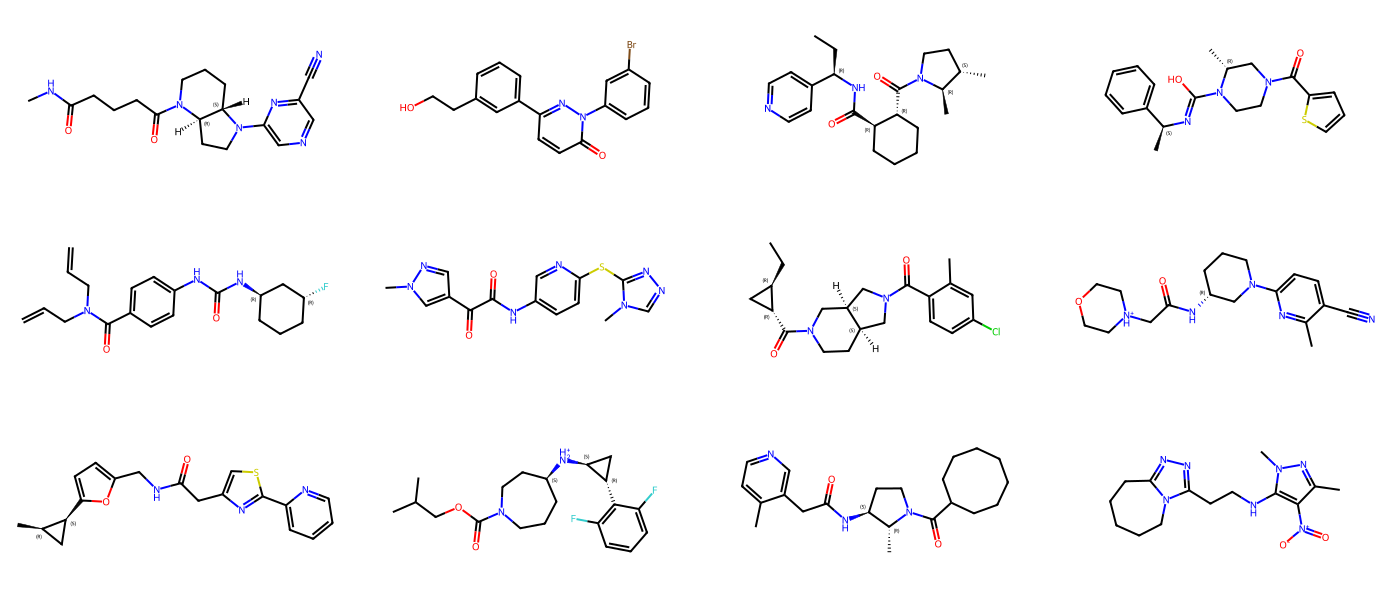

In [14]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))

### Superstructure Generation

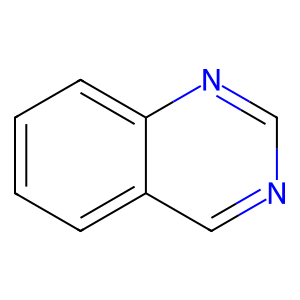

In [15]:
superstructure = "c1ccc2ncncc2c1"

dm.to_image(superstructure)

In [ ]:
generated_smiles = designer.super_structure(
    core=superstructure,
    n_samples_per_trial=200,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    attachment_point_depth=3,
)

generated_smiles

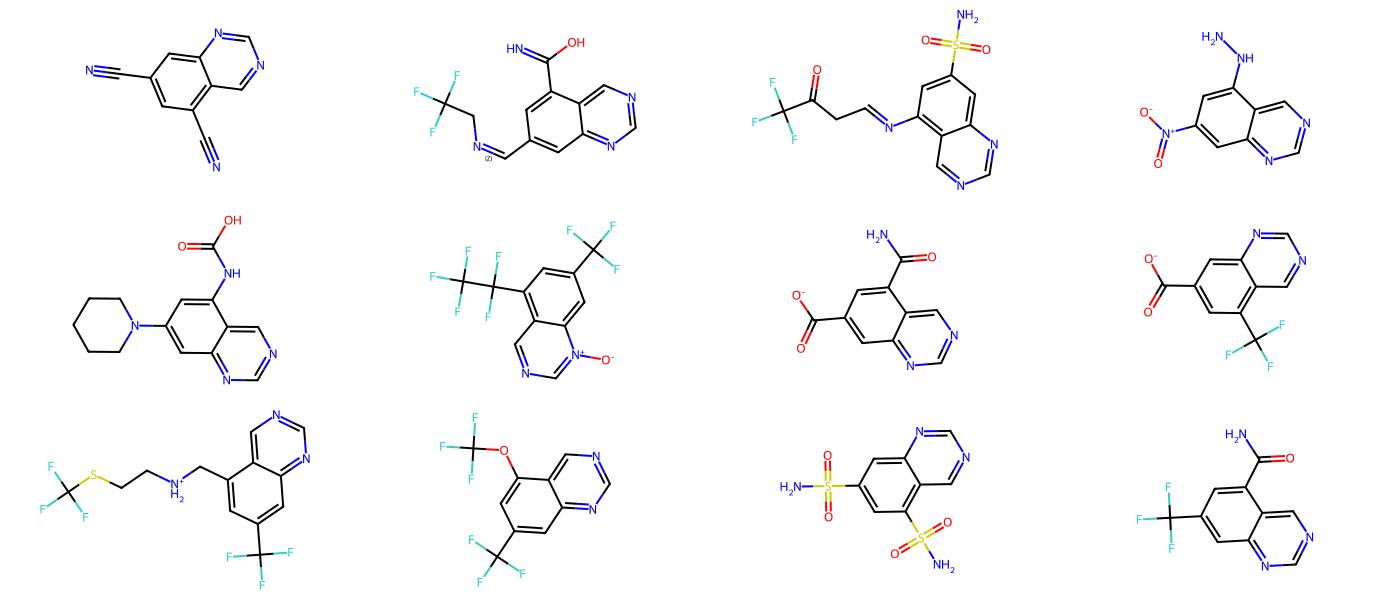

In [18]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))